# HMS - harmful brain activity

The aim of this project is to create and train a deep learning model that will detect harmful brain activity from EEG signal

Libraries we're going to use

`pandas` - a library for reading and processing data frames and input data files
`numpy` - mathematical library for efficient multidimensional algebra and raw data processing
`pytorch` - deep learning library and framework that allows for efficient data processing and neural network training using cpu or gpu
`scikit-learn` - sklearn - Rich in functionality machine learning and data science library. Industry standard for ML
`scipy` - scientific library including many mathematical tools. For example for signal processing
`os` - operating system packet that allows for navigating in the file system from the level of python

In [1]:
import pandas as pd
import numpy as np
import torch
import sklearn
import scipy
import os

We want to fully utilise our resources. We use `cuda` - a tool used by `pytorch` to perform computation on gpu - this way neural networks can be trained much faster

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Loading the data

The data comes from [kaggle](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification) competition. 

 It consists of `.parquet` files with eeg signal data as well as plotted spectrograms of the signals.

In [3]:
SAMPLING_FREQUENCY = 200
SAMPLES_IN_MEASUREMENT = 10000

In [4]:
# directory that contains data from kaggle hms
INPUT_DATA_DIR = "data"

# directory in which our npy files are/will be stored - this will allow for faster loading of the data later
PROCESSED_DATA_DIR = "processed_data"

The metadata is stored in train.csv and test.csv files

In [5]:
train_meta_full = pd.read_csv(INPUT_DATA_DIR + "/train.csv")
train_meta = train_meta_full.loc[train_meta_full["eeg_sub_id"] == 0]

test_meta = pd.read_csv(INPUT_DATA_DIR + "/test.csv")

Signal data tends to be very noisy. That's why it's important to filter the noise before processing the data further. For this we'll use the butterworth lowpass filter.

Lowpass filter filters out high and noisy frequencies. It only allows the frequencies lower than specified to pass through it.

The data is sampled at the frequency of 200Hz, we want to cut off noise frequencies higher than 20Hz

In [6]:
cutoff_freq = 20
sampling_rate = 200
order = 4
lowcut = 0.5
highcut = 20

b, a = scipy.signal.butter(
    order, (lowcut, highcut), btype="bandpass", analog=False, fs=sampling_rate
)

Extract `.parquet` data.

The training data is stored in `.parquet` files as individual read values of separate electrodes placed on patient's head during EEG examination.

Normally specialists don't analyze the separate signals but rather differences between the neighbouring electrodes. 

`extract_parquet` function computes those differences and creates time series of those differences as opposed to pure signal.

Those differences are then processed with previously initialized lowpass filter, clipped so that their values are not too high and converted to pytorch tensor objects.

We want to use pytorch tensors because it's the object class required to perform neural network training.

In [7]:
# take a parquet dataframe and compute correct values for each column
# we want columns such as "Fp1-F7" as can be seen in /example_figures
def extract_parquet(parquet_data: torch.tensor):
    parquet_data["Fp1-F7"] = parquet_data["Fp1"] - parquet_data["F7"]
    parquet_data["F7-T3"] = parquet_data["F7"] - parquet_data["T3"]
    parquet_data["T3-T5"] = parquet_data["T3"] - parquet_data["T5"]
    parquet_data["T5-O1"] = parquet_data["T5"] - parquet_data["O1"]

    parquet_data["Fp2-F8"] = parquet_data["Fp2"] - parquet_data["F8"]
    parquet_data["F8-T4"] = parquet_data["F8"] - parquet_data["T4"]
    parquet_data["T4-T6"] = parquet_data["T4"] - parquet_data["T6"]
    parquet_data["T6-O2"] = parquet_data["T6"] - parquet_data["O2"]

    parquet_data["Fp1-F3"] = parquet_data["Fp1"] - parquet_data["F3"]
    parquet_data["F3-C3"] = parquet_data["F3"] - parquet_data["C3"]
    parquet_data["C3-P3"] = parquet_data["C3"] - parquet_data["P3"]
    parquet_data["P3-O1"] = parquet_data["P3"] - parquet_data["O1"]

    parquet_data["Fp2-F4"] = parquet_data["Fp2"] - parquet_data["F4"]
    parquet_data["F4-C4"] = parquet_data["F4"] - parquet_data["C4"]
    parquet_data["C4-P4"] = parquet_data["C4"] - parquet_data["P4"]
    parquet_data["P4-O2"] = parquet_data["P4"] - parquet_data["O2"]

    parquet_data["Fz-Cz"] = parquet_data["Fz"] - parquet_data["Cz"]
    parquet_data["Cz-Pz"] = parquet_data["Cz"] - parquet_data["Pz"]

    parquet_data = parquet_data.drop(
        [
            "Fp1",
            "F3",
            "C3",
            "P3",
            "F7",
            "T3",
            "T5",
            "O1",
            "Fz",
            "Cz",
            "Pz",
            "Fp2",
            "F4",
            "C4",
            "P4",
            "F8",
            "T4",
            "T6",
            "O2",
        ],
        axis=1,
    )

    # we want to reorder the columns so that the EKG signal is at the end.
    idx = parquet_data.columns[1:].to_list() + [parquet_data.columns[0]]

    # we want to transpose the values so that they're easier to handle later
    parquet_data = parquet_data[idx].values.T

    # filter the high frequencies
    parquet_data = scipy.signal.lfilter(b, a, parquet_data, axis=0)

    # convert to pytorch tensor
    parquet_data = torch.from_numpy(parquet_data).type(torch.float32)

    # clip high values to 1024
    parquet_data = torch.clip(parquet_data, -1024, 1024)

    return parquet_data

We need to extract the data from the `.parquet` files, so in a loop we'll iterate through the metadata and extract the data and the training labels.

In [8]:
# # A list for data entries from different files
# eeg_data = []
#
# # indices of the dataframes with too many missing values
# faulty_eeg_id = []
#
# if not os.path.exists(f"{PROCESSED_DATA_DIR}/eeg_labels.pt"):
#     os.makedirs(PROCESSED_DATA_DIR,exist_ok=True)
#
#     # iterate through IDs of eeg and extract each .parquet file
#     for eeg_id in train_meta["eeg_id"]:
#         # open the file using pandas
#         parquet_data = pd.read_parquet(INPUT_DATA_DIR + f"/train_eegs/{eeg_id}.parquet")
#
#         # fill the missing values and extract the first 10000 measurements
#         parquet_data = parquet_data.interpolate(method="ffill")[:10000]
#
#         # If at this point there are any missing values, the file can't be used
#         if np.any(parquet_data.isna()):
#             faulty_eeg_id.append(eeg_id)
#             continue
#
#         # we call the preprocessing function
#         eeg = extract_parquet(parquet_data)
#
#         # and add the data to the list of processed entries
#         eeg_data.append(eeg)
#
#     # convert the list of tensors to one tensor
#     eeg_data = torch.stack(eeg_data)
#
#     # save to PROCESSED_DATA_TIR
#     torch.save(eeg_data, f"{PROCESSED_DATA_DIR}/eeg_data.pt")
#
#     # extract labels for valid entries
#     all_labels = train_meta.loc[~train_meta["eeg_id"].isin(faulty_eeg_id)]
#     eeg_labels = all_labels[
#         ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
#     ].values
#
#     # convert labels to pytorch tensor
#     eeg_labels = torch.tensor(np.array(eeg_labels), dtype=torch.float32)
#
#     # The labels are probability - they must sum to 1
#     eeg_labels = eeg_labels / eeg_labels.sum(dim=1, keepdims=True)
#
#     # save for easier training later
#     torch.save(eeg_labels, f"{PROCESSED_DATA_DIR}/eeg_labels.pt")
# else:
#     eeg_data = torch.load(f"{PROCESSED_DATA_DIR}/eeg_data.pt")
#     eeg_labels = torch.load(f"{PROCESSED_DATA_DIR}/eeg_labels.pt")

In [9]:
def retrieve_eeg_dataset():
    if not os.path.exists(f"{PROCESSED_DATA_DIR}/eeg_labels_full.pt"):
        os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

        eeg_data_full = []
        eeg_labels_full = []
        eeg_id_measurements = []

        i = 0
        # iterate through IDs of eeg and extract each .parquet file
        for eeg_id in train_meta_full["eeg_id"].unique():
            if i % 500 == 0:
                print(i)
            i += 1
            # open the file using pandas
            parquet_data = pd.read_parquet(
                INPUT_DATA_DIR + f"/train_eegs/{eeg_id}.parquet"
            )

            # read and interpolate the data
            parquet_data = extract_parquet(parquet_data.interpolate(method="ffill"))

            for idx, row in train_meta_full.loc[
                train_meta_full["eeg_id"] == eeg_id
            ].iterrows():
                offset = int(200 * row["eeg_label_offset_seconds"])

                parquet_window = parquet_data[:, offset : offset + 10000]

                # If at this point there are any missing values, the file can't be used
                if torch.any(parquet_window.isnan()):
                    continue

                # and add the data to the list of processed entries
                eeg_data_full.append(parquet_window)
                eeg_labels_full.append(
                    row[
                        [
                            "seizure_vote",
                            "lpd_vote",
                            "gpd_vote",
                            "lrda_vote",
                            "grda_vote",
                            "other_vote",
                        ]
                    ].values
                )
                eeg_id_measurements.append(eeg_id)

        # convert the list of tensors to one tensor
        print("stacking eeg")
        eeg_data_full = torch.stack(eeg_data_full)

        # save to PROCESSED_DATA_TIR
        print("saving eeg")
        torch.save(eeg_data_full, f"{PROCESSED_DATA_DIR}/eeg_data_full.pt")

        # stack labels to one numpy array and convert to pytorch tensor
        print("stacking labels")
        eeg_labels_full = np.vstack(eeg_labels_full)
        print("converting labels")
        eeg_labels_full = torch.from_numpy(eeg_labels_full.astype(np.float32))

        # The labels represent probability - they must sum to 1
        print("labels -> distribution")
        eeg_labels_full = eeg_labels_full / eeg_labels_full.sum(dim=1, keepdims=True)

        # save for easier reuse later
        print("saving labels")
        torch.save(eeg_labels_full, f"{PROCESSED_DATA_DIR}/eeg_labels_full.pt")

        eeg_id_measurements = torch.tensor(np.array(eeg_id_measurements))
        torch.save(eeg_id_measurements, f"{PROCESSED_DATA_DIR}/eeg_id_measuerements.pt")
    else:
        eeg_data_full = torch.load(f"{PROCESSED_DATA_DIR}/eeg_data_full.pt")
        eeg_labels_full = torch.load(f"{PROCESSED_DATA_DIR}/eeg_labels_full.pt")
        eeg_id_measurements = torch.load(
            f"{PROCESSED_DATA_DIR}/eeg_id_measuerements.pt"
        )
    return eeg_data_full, eeg_labels_full, eeg_id_measurements

In [5]:
from sklearn.model_selection import train_test_split

if not os.path.exists(f"{PROCESSED_DATA_DIR}/labels_valid.pt"):
    eeg_data_full, eeg_labels_full, eeg_id_measurements = retrieve_eeg_dataset()

    id_train, id_test = train_test_split(
        torch.unique(eeg_id_measurements), test_size=0.2
    )

    id_test, id_valid = train_test_split(id_test, test_size=0.5)

    train_idx = torch.isin(eeg_id_measurements, id_train)
    test_idx = torch.isin(eeg_id_measurements, id_test)
    valid_idx = torch.isin(eeg_id_measurements, id_valid)
    del eeg_id_measurements

    X_train, y_train = eeg_data_full[train_idx], eeg_labels_full[train_idx]
    X_test, y_test = eeg_data_full[test_idx], eeg_labels_full[test_idx]
    X_valid, y_valid = eeg_data_full[valid_idx], eeg_labels_full[valid_idx]
    del eeg_data_full
    del eeg_labels_full

    torch.save(X_train, f"{PROCESSED_DATA_DIR}/eeg_train.pt")
    torch.save(y_train, f"{PROCESSED_DATA_DIR}/labels_train.pt")
    torch.save(X_test, f"{PROCESSED_DATA_DIR}/eeg_test.pt")
    torch.save(y_test, f"{PROCESSED_DATA_DIR}/labels_test.pt")
    torch.save(X_valid, f"{PROCESSED_DATA_DIR}/eeg_valid.pt")
    torch.save(y_valid, f"{PROCESSED_DATA_DIR}/labels_valid.pt")
else:
    X_train = torch.load(f"{PROCESSED_DATA_DIR}/eeg_train.pt")
    y_train = torch.load(f"{PROCESSED_DATA_DIR}/labels_train.pt")
    X_test = torch.load(f"{PROCESSED_DATA_DIR}/eeg_test.pt")
    y_test = torch.load(f"{PROCESSED_DATA_DIR}/labels_test.pt")
    X_valid = torch.load(f"{PROCESSED_DATA_DIR}/eeg_valid.pt")
    y_valid = torch.load(f"{PROCESSED_DATA_DIR}/labels_valid.pt")

---

# Creating a data loader, preprocessing

Using scikit-learn we'll split the data into training and testing dataset

In [11]:
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(
#     eeg_data_full, eeg_labels_full, test_size=0.2
# )
#
# X_test, X_valid, y_test, y_valid = train_test_split(
#     X_test, y_test, test_size=0.5
# )

To perform the computation on gpu, we have to move the data into cuda

In [12]:
# X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
# X_valid, y_valid = X_valid.to(DEVICE), y_valid.to(DEVICE)
# X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

Create a HMS dataset class that will help us load the data during the model training

In [29]:
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE = 512


class CustomImageDataset(Dataset):
    def __init__(self, X, y, train=False):
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(
    CustomImageDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True
)

test_loader = DataLoader(
    CustomImageDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True
)

valid_loader = DataLoader(
    CustomImageDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=True
)

In [103]:
train_loader

---

# Creating a model

We create a machine learning model - a python object that will be trained to predict correct data labels

In [7]:
import torch.nn as nn


class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            # (19, 2000)
            nn.Conv1d(19, 76, kernel_size=5, padding=2, groups=19),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(76),
            # (32, 1000)
        )

        self.conv2 = nn.Sequential(
            # (32, 1000)
            nn.Conv1d(76, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(32),
            # (32, 500)
        )

        self.conv3 = nn.Sequential(
            # (32, 500)
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(32),
            # (32, 125)
        )

        self.conv4 = nn.Sequential(
            # (32, 125)
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            # (32,125)
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(8000, 1024),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 6),
        )

    # input in CHW / CW format
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.mlp(x)
        return x

---

# Training

After data preprocessing and buikding the model we need to train it. 

We'll use a [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) as a loss function. 
KLDivergence is the widely used metric suggested by the scientists who worked on the best solutions for the HMS competition.

We also use Adam optimizier - an adaptive learning rate optimization algorithm used in training deep learning models.

It combines the advantages of two other extensions of stochastic gradient descent 
- (SGD): Adaptive Gradient Algorithm (AdaGrad) 
- Root Mean Square Propagation (RMSProp)

It adjusts the learning rate for each parameter dynamically, making it efficient and well-suited for large datasets and complex models.

In [9]:
from torch.optim import Adam

# initialize the model and move it to gpu
model = ConvModel()

In [14]:
softmax = nn.Softmax(1)
relu = nn.ReLU()
log_softmax = lambda x: nn.functional.log_softmax(x, dim=1)

In [31]:
def rate_model(loader, loss_function, activation):
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        iteration = 0
        total_loss = 0
        for batch in loader:
            # extract data and labels
            batch_data, batch_labels = batch
            rand_idx = torch.randint(8000, (1,))[0]
            batch_data = batch_data[:, :, rand_idx : rand_idx + 2000]
            batch_data = batch_data.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            # perform the inference on the data
            prediction = model(batch_data)
            prediction = activation(prediction)

            # compare the inference output with real labels and calculate the value of loss function
            loss = loss_function(prediction, batch_labels)

            # accumulate loss
            total_loss += float(loss.item())

            iteration += 1

    model.train()
    return total_loss / iteration

In [56]:
def evaluate_model(loader, loss_function, activation):
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        iteration = 0
        total_loss = 0
        for batch in loader:
            # extract data and labels
            batch_data, batch_labels = batch
            batch_data = batch_data.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            predictions = []
            for i in range(5):
                batch_part = batch_data[:, :, i : i + 2000]

                # perform the inference on the data
                prediction = model(batch_part)
                prediction = activation(prediction)
                # prediction = activation(prediction) - 0.1
                # prediction = relu(prediction)
                # prediction /= prediction.sum(axis=-1,keepdims=True)
                predictions.append(prediction)
            predictions = torch.stack(predictions).mean(axis=0)

            # compare the inference output with real labels and calculate the value of loss function
            loss = loss_function(predictions, batch_labels)

            # accumulate loss
            total_loss += float(loss.item())

            iteration += 1

    model.train()
    return total_loss / iteration

## Pretraining 1 - regression

In [176]:
# Create an optimizer that will perform the gradient descent algorithm
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loss_function = nn.MSELoss()

In [130]:
os.makedirs(f"{PROCESSED_DATA_DIR}/model_state", exist_ok=True)

In [122]:
train_losses_pretraining = []
valid_losses_pretraining = []

In [137]:
EPOCHS = 100

model.train()

model.to(DEVICE)
# we train the network for EPOCHS epochs
for epoch in range(EPOCHS):
    # variables that will let us compute average epoch loss
    iteration = 0
    total_loss = 0

    # iterate through data batches in the data loader
    for batch in train_loader:
        # extract data and labels
        batch_data, batch_labels = batch
        rand_idx = torch.randint(8000, (1,))[0]
        batch_data = batch_data[:, :, rand_idx : rand_idx + 2000]
        batch_data = batch_data.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        # perform the inference on the data
        prediction = model(batch_data)
        prediction = softmax(
            prediction + torch.normal(0, 0.3, size=(batch_labels.shape)).to(DEVICE)
        )

        # compare the inference output with real labels and calculate the value of loss function
        loss = loss_function(prediction, batch_labels)

        # accumulate loss to print the average at the end of the epoch
        total_loss += float(loss.item())

        # reset the optimizer
        optimizer.zero_grad()

        # compute the error backpropagation
        loss.backward()

        # update the weights of the model
        optimizer.step()

        iteration += 1

    train_losses_pretraining.append(total_loss / iteration)
    valid_losses_pretraining.append(rate_model(valid_loader, nn.MSELoss(), softmax))

    print(f"epoch      : {epoch}")
    print(f"train loss : {train_losses_pretraining[-1]}")
    print(f"valid loss : {valid_losses_pretraining[-1]}")
    print("\n")

    if epoch % 10 == 9:
        torch.save(
            model.cpu().state_dict(),
            f"{PROCESSED_DATA_DIR}/model_state/pretraining_state{epoch+1}",
        )
        model.to(DEVICE)

epoch      : 50
train loss : 0.06119419119574807
valid loss : 0.06519405242233049

epoch      : 51
train loss : 0.06112707085681684
valid loss : 0.06441088907775425

epoch      : 52
train loss : 0.06063878123055805
valid loss : 0.0639836426292147

epoch      : 53
train loss : 0.06059238520084005
valid loss : 0.0645886952323573

epoch      : 54
train loss : 0.06034481067097548
valid loss : 0.0633350337545077

epoch      : 55
train loss : 0.0602013250869332
valid loss : 0.06422466766976175

epoch      : 56
train loss : 0.06022001376206225
valid loss : 0.06357007047959737

epoch      : 57
train loss : 0.059937641656760014
valid loss : 0.06473148117462794

epoch      : 58
train loss : 0.05999661498900616
valid loss : 0.06385690807586625

epoch      : 59
train loss : 0.0594283644222852
valid loss : 0.06507233548022452

epoch      : 60
train loss : 0.05926700573075901
valid loss : 0.06269138501513571

epoch      : 61
train loss : 0.059367327234058666
valid loss : 0.06416317501238414

epoch  

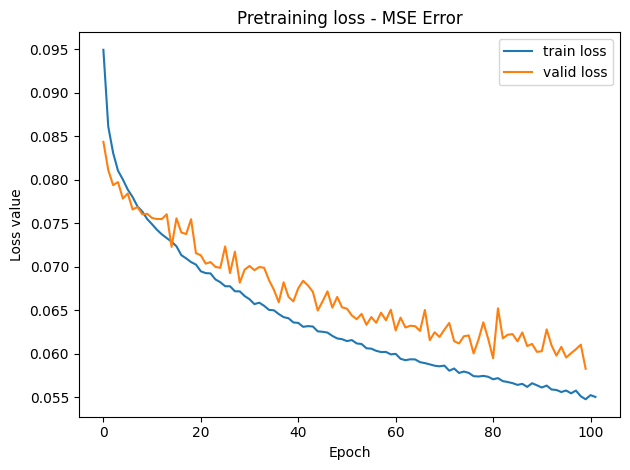

In [192]:
from matplotlib import pyplot as plt

os.makedirs(f"{PROCESSED_DATA_DIR}/results", exist_ok=True)

torch.save(
    torch.tensor(train_losses_pretraining),
    f"{PROCESSED_DATA_DIR}/results/train_losses_pretraining.pt",
)
torch.save(
    torch.tensor(valid_losses_pretraining),
    f"{PROCESSED_DATA_DIR}/results/valid_losses_pretraining.pt",
)

plt.plot(train_losses_pretraining, label="train loss")
plt.plot(valid_losses_pretraining, label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title("Pretraining loss - MSE Error")
plt.legend()

plt.tight_layout()
plt.savefig(f"{PROCESSED_DATA_DIR}/results/pretraining.pdf")

In [11]:
model.load_state_dict(
    torch.load(PROCESSED_DATA_DIR + "/model_state_finished/training_state200")
)

<All keys matched successfully>

In [32]:
rate_model(test_loader, nn.MSELoss(), softmax)

0.05626846229036649

---

## Final training

In [150]:
model.load_state_dict(torch.load("processed_data/model_state/pretraining_state100"))

<All keys matched successfully>

In [151]:
# Create an optimizer that will perform the gradient descent algorithm
optimizer = Adam(model.parameters(), lr=1e-4)

# As a loss function we'll be using KLDivergence
# loss_function = nn.KLDivLoss(reduction="batchmean", log_target=False)
loss_function = nn.KLDivLoss(reduction="batchmean", log_target=False)

In [152]:
train_losses_training = []
valid_losses_training = []

In [153]:
EPOCHS = 200

model.train()

# we train the network for EPOCHS epochs
for epoch in range(EPOCHS):
    # variables that will let us compute average epoch loss
    iteration = 0
    total_loss = 0

    # iterate through data batches in the data loader
    for batch in train_loader:
        # extract data and labels
        batch_data, batch_labels = batch
        rand_idx = torch.randint(8000, (1,))[0]
        batch_data = batch_data[:, :, rand_idx : rand_idx + 2000]
        batch_data = batch_data.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        # perform the inference on the data
        prediction = model(batch_data)

        # compare the inference output with real labels and calculate the value of loss function
        loss = loss_function(
            nn.functional.log_softmax(
                prediction + torch.normal(0, 0.3, size=(batch_labels.shape)).to(DEVICE),
                dim=1,
            ),
            batch_labels,
        )

        # accumulate loss to print the average at the end of the epoch
        total_loss += float(loss.item())

        # reset the optimizer
        optimizer.zero_grad()

        # compute the error backpropagation
        loss.backward()

        # update the weights of the model
        optimizer.step()

        iteration += 1

    train_losses_training.append(total_loss / iteration)
    valid_losses_training.append(rate_model(valid_loader, loss_function, log_softmax))

    print(f"epoch      : {epoch}")
    print(f"train loss : {train_losses_training[-1]}")
    print(f"valid loss : {valid_losses_training[-1]}")
    print("\n")

    if epoch % 10 == 9:
        torch.save(
            model.cpu().state_dict(),
            f"{PROCESSED_DATA_DIR}/model_state/training_state{epoch+1}",
        )
        model.to(DEVICE)

epoch      : 0
train loss : 0.7955408472003359
valid loss : 0.8501955128851391

epoch      : 1
train loss : 0.7880919633489667
valid loss : 0.8522392511367798

epoch      : 2
train loss : 0.7811194531845324
valid loss : 0.8277531322978792

epoch      : 3
train loss : 0.7777933099053123
valid loss : 0.8393637396040416

epoch      : 4
train loss : 0.774833923036402
valid loss : 0.8619680943943205

epoch      : 5
train loss : 0.7716333508491516
valid loss : 0.8219453011240277

epoch      : 6
train loss : 0.7718890081752431
valid loss : 0.8258639034770784

epoch      : 7
train loss : 0.7701075326312672
valid loss : 0.8509665699232192

epoch      : 8
train loss : 0.7673023614016447
valid loss : 0.8389667272567749

epoch      : 9
train loss : 0.7629393256071842
valid loss : 0.8141592996461051

epoch      : 10
train loss : 0.7681393352421847
valid loss : 0.8458239067168463

epoch      : 11
train loss : 0.7621383620030953
valid loss : 0.8208627246675038

epoch      : 12
train loss : 0.75787972

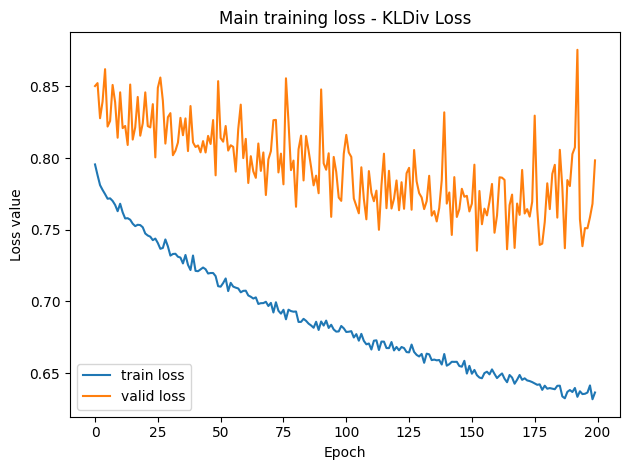

In [191]:
torch.save(
    torch.tensor(train_losses_training),
    f"{PROCESSED_DATA_DIR}/results/train_losses_training.pt",
)
torch.save(
    torch.tensor(valid_losses_training),
    f"{PROCESSED_DATA_DIR}/results/valid_losses_training.pt",
)

plt.plot(train_losses_training, label="train loss")
plt.plot(valid_losses_training, label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title("Main training loss - KLDiv Loss")
plt.legend()

plt.tight_layout()
plt.savefig(f"{PROCESSED_DATA_DIR}/results/training.pdf")

In [65]:
rate_model(
    test_loader, nn.KLDivLoss(reduction="batchmean", log_target=False), log_softmax
)

0.8596249744296074

In [85]:
rnd = torch.randint(5000, (10,))
l, d = y_train[rnd], X_train[rnd]
model.eval()
p = model(d[:, :, :2000].to(DEVICE))
model.train()

p = softmax(p)

# p = relu(softmax(p)-0.05)
# p/=p.sum(axis=1,keepdims=True)

In [86]:
l

tensor([[0.2667, 0.0000, 0.7333, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6000, 0.0667, 0.3333],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.1250, 0.0000, 0.0625, 0.6875, 0.0625, 0.0625],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0769, 0.0000, 0.0769, 0.8462],
        [0.0000, 0.0000, 0.0000, 0.6000, 0.0667, 0.3333]])

In [87]:
p

tensor([[3.0676e-01, 5.1204e-04, 6.8808e-01, 3.9829e-06, 1.8835e-05, 4.6224e-03],
        [9.4891e-05, 4.2091e-07, 4.6020e-10, 6.9421e-01, 4.2623e-02, 2.6307e-01],
        [2.9515e-03, 3.1368e-04, 4.7113e-05, 8.1502e-01, 1.0763e-01, 7.4040e-02],
        [8.9533e-01, 1.1813e-02, 2.5601e-02, 3.0434e-03, 8.2658e-03, 5.5948e-02],
        [5.0582e-03, 9.3761e-01, 1.8414e-02, 1.2433e-03, 1.4528e-03, 3.6218e-02],
        [3.1080e-01, 3.1601e-02, 1.7722e-01, 8.2432e-03, 1.3298e-01, 3.3916e-01],
        [5.0763e-02, 5.1732e-02, 4.4158e-02, 7.1876e-01, 5.1128e-02, 8.3457e-02],
        [1.0110e-04, 4.0596e-04, 3.1504e-04, 1.3797e-03, 9.9254e-01, 5.2608e-03],
        [3.0929e-01, 3.5674e-02, 1.5989e-01, 9.0217e-03, 1.4646e-01, 3.3966e-01],
        [1.0729e-04, 6.0654e-07, 5.2821e-10, 6.7861e-01, 5.0754e-02, 2.7053e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

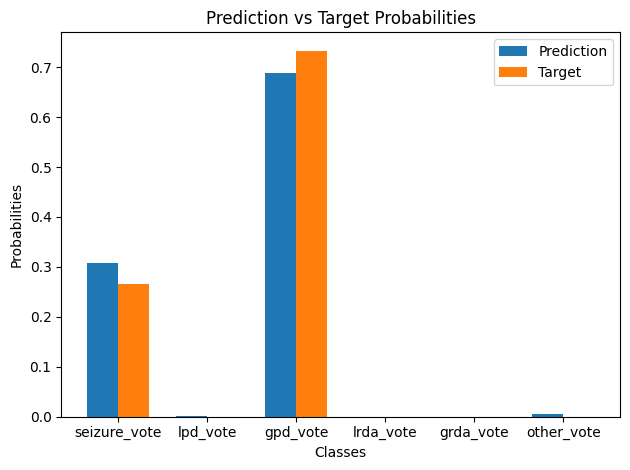

In [88]:
bar_width = 0.35  # Width of the bars
index = np.arange(6)

fig, ax = plt.subplots()
bar1 = ax.bar(index, p[0].cpu().detach().numpy(), bar_width, label="Prediction")
bar2 = ax.bar(index + bar_width, l[0].cpu().detach().numpy(), bar_width, label="Target")

# Add labels, title, and legend
ax.set_xlabel("Classes")
ax.set_ylabel("Probabilities")
ax.set_title("Prediction vs Target Probabilities")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(
    ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
)
ax.legend()
plt.tight_layout()
plt.savefig(f"{PROCESSED_DATA_DIR}/results_finished/example_prediction2.pdf")
plt.show()